# Irwin investigations

### Improve solar inputs to model?

In [1]:
# librariies
import xarray as xr
import numpy as np
import pandas as pd

from snobedo.snotel import SnotelLocations

from snobedo.lib.dask_utils import start_cluster, client_ip_and_port

from pathlib import Path, PurePath

import matplotlib.pyplot as plt

In [72]:
client = start_cluster(8, 24)
client_ip_and_port(client)

2024-10-31 16:11:35,636 - tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOMainLoop object at 0x7fc061cec110>>, <Task finished name='Task-16' coro=<SpecCluster._correct_state_internal() done, defined at /uufs/chpc.utah.edu/common/home/u1037042/software/pkg/miniconda3/envs/snow_viz/lib/python3.12/site-packages/distributed/deploy/spec.py:346> exception=RuntimeError('Command exited with non-zero exit code.\nExit code: 1\nCommand:\nsbatch /scratch/local/u1037042/2143910/tmpscowkjr2.sh\nstdout:\n\nstderr:\nsbatch: error: Batch job submission failed: Unable to contact slurm controller (connect failure)\n\n')>)
Traceback (most recent call last):
  File "/uufs/chpc.utah.edu/common/home/u1037042/software/pkg/miniconda3/envs/snow_viz/lib/python3.12/site-packages/tornado/ioloop.py", line 750, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/uufs/chpc.utah.edu/common/home/u103704

10.242.76.197:8787


In [68]:
# paths
SHARED_STORE = PurePath('/uufs/chpc.utah.edu/common/home/skiles-group1')
DATA_DIR = SHARED_STORE.joinpath('jmeyer')
SNOTEL_DIR = DATA_DIR.joinpath( 'Snotel')


year = 2022
water_year = f'wy{year}'

### Get snotel data

In [69]:
# focus on IRWIN
from pathlib import Path, PurePath
snotel_sites = SnotelLocations()
snotel_sites.load_from_json(SNOTEL_DIR / 'site-locations/snotel_sites.json')
snotel_sites.Irwin

SnotelSite(name='Irwin', lon=[317131], lat=[4306375])

### Read in model outputs (3)

In [5]:
# 1. smrf model
smrf_eb = xr.open_mfdataset(
    f'{SHARED_STORE}/erw_isnobal/{water_year}/erw/run*/smrf_energy*.nc',
    parallel=True, chunks={'time': 24}, #, 'y' :10, 'x': 10},
)

irwin_snobal = smrf_eb.net_solar.sel(x=snotel_sites.Irwin.lon, y=snotel_sites.Irwin.lat, method='nearest').squeeze(['x', 'y']).compute()

irwin_snobal_a_ir = smrf_eb.albedo_ir.sel(x=snotel_sites.Irwin.lon, y=snotel_sites.Irwin.lat, method='nearest').squeeze(['x', 'y']).compute()
irwin_snobal_a_vis = smrf_eb.albedo_vis.sel(x=snotel_sites.Irwin.lon, y=snotel_sites.Irwin.lat, method='nearest').squeeze(['x', 'y']).compute()
irwin_snobal_albedo = (0.67*irwin_snobal_a_vis)+(0.33*irwin_snobal_a_ir)

del smrf_eb

In [6]:
# 2. HRRR + Solar
# *** this one has error
HRRR_solar = xr.open_mfdataset(
    f'{SHARED_STORE}/erw_isnobal/{water_year}/erw_hrrr_solar/run*/net_solar.nc',
    parallel=True, chunks={'time': 24}, # 'y' :10, 'x': 10},
    drop_variables=['DSWRF', 'illumination_angle', 'zenith', 'azimuth', 'albedo_vis', 'albedo_ir'],
)

irwin_snobal_hrrr = HRRR_solar.net_solar.sel(x=snotel_sites.Irwin.lon, y=snotel_sites.Irwin.lat, method='nearest').squeeze(['x', 'y']).compute()

In [7]:
# 3. HRRR + MODIS
HRRR_solar = xr.open_mfdataset(
    f'{SHARED_STORE}/erw_isnobal/{water_year}/erw_hrrr_solar_modis_cubic/run*/net_solar.nc',
    parallel=True, chunks={'time': 24}, # 'y' :10, 'x': 10},
    drop_variables=['DSWRF', 'illumination_angle'],
)

irwin_snobal_hrrr_modis = HRRR_solar.net_solar.sel(x=snotel_sites.Irwin.lon, y=snotel_sites.Irwin.lat, method='nearest').squeeze(['x', 'y']).compute()
irwin_snobal_hrrr_modis_albedo = HRRR_solar.albedo.sel(x=snotel_sites.Irwin.lon, y=snotel_sites.Irwin.lat, method='nearest').squeeze(['x', 'y']).compute()/10000

del HRRR_solar

In [8]:
irwin_snobal_hrrr

<xarray.DataArray 'net_solar' (time: 7296)> Size: 29kB
array([  0.42664516,   0.        ,   0.        , ..., 207.04594   ,
       226.89696   ,  89.48064   ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 58kB 2021-10-01 ... 2022-07-31T23:00:00
    x        float32 4B 3.171e+05
    y        float32 4B 4.306e+06
Attributes:
    grid_mapping:  projection

In [9]:
irwin_snobal_hrrr_modis_solar = irwin_snobal_hrrr_modis / (1 - irwin_snobal_hrrr_modis_albedo)
irwin_snobal_hrrr_solar = irwin_snobal_hrrr / (1 - irwin_snobal_albedo)
irwin_snobal_solar = irwin_snobal / (1 - irwin_snobal_albedo)

In [10]:
STATION_LABEL = 'Station'
SNOW_GONE = {
'Irwin Study Plot': {
            STATION_LABEL: np.datetime64('2022-06-01'),
            'HRRR-MODIS': np.datetime64('2022-07-08'),
            'HRRR-SC': np.datetime64('2022-06-05'),
            'Time-Decay': np.datetime64('2022-06-05'),        
        }
}
SNOW_ONSET = {
    '2022': {
        'Butte': np.datetime64('2021-11-01'),
        'Schofield Pass': np.datetime64('2021-10-08'),
        'Irwin Study Plot': np.datetime64('2021-10-11'),
    }
}

In [11]:
def with_snow_at_site(site_name, data):
    return data[data.time.dt.hour == 18].where(
        data.time >= SNOW_ONSET[str(year)][site_name]
    ).where(
        data.time <= SNOW_GONE[str(year)][site_name][STATION_LABEL]
    )

In [12]:
def df_with_snow_at_site(site_name, df):
    return df[
        (df.index >= SNOW_ONSET[str(year)][site_name]) & \
        (df.index <= SNOW_GONE[str(year)][site_name][STATION_LABEL])
    ]

In [13]:
# Snotel
# removed filtering unrealistic data
# removed rolling window
PD_OPTS = dict(
    parse_dates=True,
    index_col=0,
    names=['Temp', 'VIS_IN', 'NIR_IN', 'VIS_OUT', 'NIR_OUT'],
    header=0,
)
irwin_pyra = pd.concat([
    pd.read_csv(DATA_DIR / 'Snotel/wy2021/Irwin/2021-Irwin.csv', **PD_OPTS),
    pd.read_csv(DATA_DIR / 'Snotel/wy2022/Irwin/2022-Irwin.csv', **PD_OPTS),
])
irwin_pyra = irwin_pyra.fillna({'VIS_IN': 0}).astype(np.float64)

# add net solar
# removed
# ROLL_WINDOW = 32
# .rolling(ROLL_WINDOW).mean().interpolate('time')
irwin_pyra['net_solar'] = (
    irwin_pyra['VIS_IN'] + irwin_pyra['NIR_IN'] - irwin_pyra['VIS_OUT'] - irwin_pyra['NIR_OUT']
)
irwin_pyra['albedo'] = (
    (0.67 * (irwin_pyra['VIS_OUT'] / irwin_pyra['VIS_IN'])) + (0.33 * (irwin_pyra['NIR_OUT'] / irwin_pyra['NIR_IN']))
)

irwin_pyra

Temp      VIS_IN      NIR_IN    VIS_OUT    NIR_OUT  \
2020-10-01 00:00:00  17.720  163.543700  103.276300  11.493210   9.229739   
2020-10-01 00:15:00  16.440   63.947490   33.248880   4.676552   3.648914   
2020-10-01 00:30:00  14.660   15.168280    0.537851   2.475997   1.642848   
2020-10-01 00:45:00  13.020    9.152243   -0.413845   1.890282   1.210260   
2020-10-01 01:00:00  11.750    3.064336   -1.182064   1.390139   1.077668   
...                     ...         ...         ...        ...        ...   
2022-06-25 13:30:00   1.267   67.807140   19.912140   9.272700   6.692386   
2022-06-25 13:45:00   1.821  274.049800  124.711700  26.574190  21.086890   
2022-06-25 14:00:00   4.256  340.697400  167.584100  45.274410  36.379280   
2022-06-25 14:15:00   7.532  382.882000  191.219500  58.465750  46.475040   
2022-06-25 14:30:00  10.430  488.592800  215.494200  68.870220  54.482830   

                      net_solar    albedo  
2020-10-01 00:00:00  246.097051  0.076577  
2020-10-01 00:15:00   88.870904  0.085214  
2020-10-01 00:30:00   11.587285  1.117343  
2020-10-01 00:45:00    5.637856 -0.826682  
2020-10-01 01:00:00   -0.585535  0.003091  
...                         ...       ...  
2022-06-25 13:30:00   71.754194  0.202535  
2022-06-25 13:45:00  351.100420  0.120767  
2022-06-25 14:00:00  426.627810  0.160671  
2022-06-25 14:15:00  469.160710  0.182513  
2022-06-25 14:30:00  580.733950  0.177874  

[60731 rows x 7 columns]

### Single image plot raster

In [14]:
# plotting params
COLORS = {
        'HRRR-MODIS': 'cornflowerblue',
        'HRRR-SC': 'lightcoral',
        'Time-Decay': 'sandybrown',
        STATION_LABEL: 'seagreen',    
}

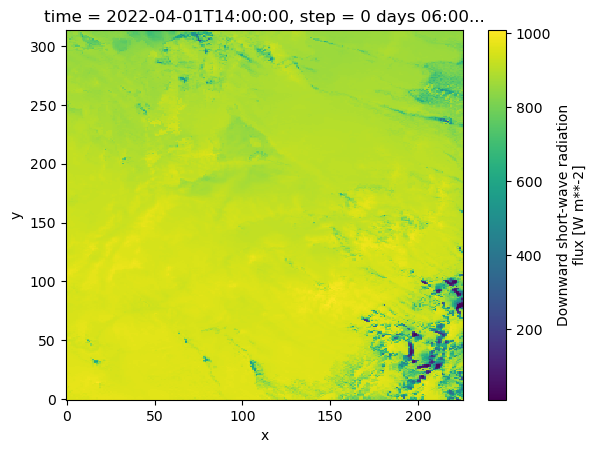

In [15]:
# '/uufs/chpc.utah.edu/common/home/skiles-group1/HRRR_water_years/2022'
# what is domain?
# hrrr_test = xr.open_mfdataset(
#     '/uufs/chpc.utah.edu/common/home/skiles-group1/HRRR_water_years/2022/hrrr.20220401/hrrr.t14z.wrfsfcf06.grib2'
# )
# hrrr_test
# hrrr_test.net_solar.plot()

# DatasetBuildError: multiple values for unique key, try re-open the file with one of:
#     filter_by_keys={'typeOfLevel': 'surface'}
#     filter_by_keys={'typeOfLevel': 'heightAboveGround'}
#     filter_by_keys={'typeOfLevel': 'boundaryLayerCloudLayer'}
#     filter_by_keys={'typeOfLevel': 'atmosphere'}

xx = xr.open_dataset('/uufs/chpc.utah.edu/common/home/skiles-group1/HRRR_water_years/2022/hrrr.20220401/hrrr.t14z.wrfsfcf06.grib2', 
    filter_by_keys={ 'level': 0, 'stepType': 'instant', 'cfVarName': 'dswrf', 'typeOfLevel': 'surface'}, 
    engine="cfgrib")
xx.dswrf.plot()

### Reproject and extract value for single image

In [16]:
import cartopy.crs as ccrs
import metpy

projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,
                                                     semiminor_axis=6371229))

xx = xx.metpy.assign_crs(
    grid_mapping_name = "lambert_conformal_conic",
    latitude_of_projection_origin=xx.dswrf.GRIB_LaDInDegrees,
    longitude_of_central_meridian=xx.dswrf.GRIB_LoVInDegrees,
    standard_parallel=(xx.dswrf.GRIB_Latin1InDegrees, xx.dswrf.GRIB_Latin2InDegrees),
    earth_radius=6371229.)

xx = xx.metpy.assign_y_x()

/scratch/local/u1037042/2143910/ipykernel_2668810/1756178536.py:17: UserWarning: More than one time coordinate present for variable  "dswrf".
  xx = xx.metpy.assign_y_x()


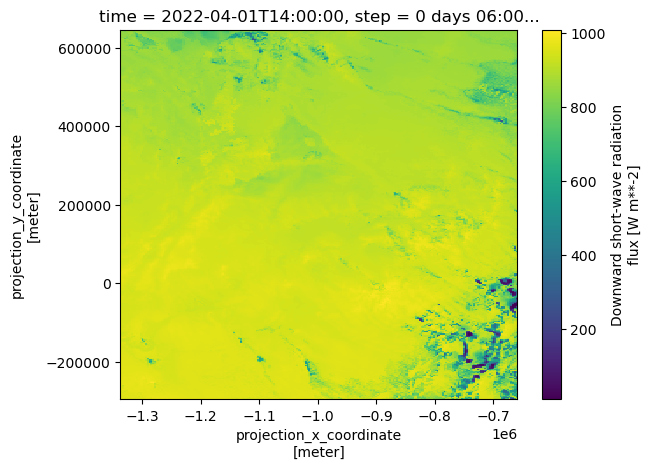

In [17]:
xx.dswrf.plot()

In [18]:
snotel_sites.Irwin.lon

[317131]

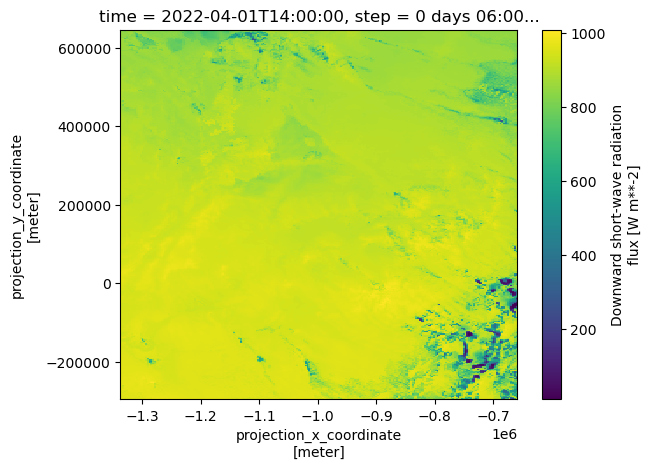

In [19]:
# Plot the raster
xx['dswrf'].plot()

# Add a point at (x, y) coordinates
plt.scatter(snotel_sites.Irwin.lon, snotel_sites.Irwin.lat, color='red')

plt.show()

#### DOES NOT WORK!!!

In [20]:
# extract value
swpix = xx.dswrf.sel(x=snotel_sites.Irwin.lon, y=snotel_sites.Irwin.lat, method='nearest').squeeze(['x', 'y']).compute()
swpix.values

array(847., dtype=float32)

### reproject

In [21]:
xx

<xarray.Dataset> Size: 1MB
Dimensions:     (y: 314, x: 226)
Coordinates:
    time        datetime64[ns] 8B ...
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
    latitude    (y, x) float64 568kB 34.9 34.9 34.9 34.91 ... 44.02 44.02 44.02
    longitude   (y, x) float64 568kB 247.8 247.9 247.9 ... 254.2 254.2 254.3
    valid_time  datetime64[ns] 8B ...
    metpy_crs   object 8B Projection: lambert_conformal_conic
  * y           (y) float64 3kB -2.943e+05 -2.913e+05 ... 6.417e+05 6.447e+05
  * x           (x) float64 2kB -1.336e+06 -1.333e+06 ... -6.635e+05 -6.605e+05
Data variables:
    dswrf       (y, x) float32 284kB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-10-31T14:32 GRIB to CDM+CF via cfgrib-0.9.1...

In [22]:
def reproject_data(ds, source_proj, target_proj):
    # Create a meshgrid of the original coordinates
    lon, lat = np.meshgrid(ds['x'].values, ds['y'].values)

    # Transform the coordinates to the target projection
    transformed_coords = target_proj.transform_points(source_proj, lon.flatten(), lat.flatten())
    transformed_lon = transformed_coords[:, 0].reshape(lon.shape)
    transformed_lat = transformed_coords[:, 1].reshape(lat.shape)

    # Create a new xarray DataArray with the reprojected coordinates
    reprojected_da = ds.interp(x=transformed_lon, y=transformed_lat)
    return reprojected_da


wgs84_proj = ccrs.PlateCarree()

In [23]:
len(xx['longitude'])
# len(xx['x'])

314

In [24]:
# lon, lat = np.meshgrid(xx['x'].values, xx['x'].values)

# # Transform the coordinates to the target projection
# transformed_coords = wgs84_proj.transform_points(projection, lon.flatten(), lat.flatten())
# transformed_lon = transformed_coords[:, 0].reshape(lon.shape)
# transformed_lat = transformed_coords[:, 1].reshape(lat.shape)

# # Create a new xarray DataArray with the reprojected coordinates
# reprojected_da = xx.dswrf.interp(x=transformed_lon, y=transformed_lat, method='linear')
# reprojected_da

In [25]:
# transformed_lon

In [26]:
# reprojected_ds = reproject_data(xx, projection, wgs84_proj)  # Replace 'temperature' with your variable name
# reprojected_ds

### Timeseries

In [27]:
### 

In [73]:
# read in original HRRR data
hrrr_2022_base = '/uufs/chpc.utah.edu/common/home/skiles-group1/erw_isnobal/wy2022/erw_hrrr_solar/'


HRRR_solar_0 = xr.open_mfdataset(
    f'{SHARED_STORE}/erw_isnobal/{water_year}/erw_hrrr_solar/run*/net_solar.nc',
    parallel=True, chunks={'time': 24}, # 'y' :10, 'x': 10},
    drop_variables=['DSWRF', 'illumination_angle', 'zenith', 'azimuth', 'albedo_vis', 'albedo_ir'],
)

In [74]:
HRRR_solar_0.net_solar

<xarray.DataArray 'net_solar' (time: 7296, y: 837, x: 656)> Size: 16GB
dask.array<concatenate, shape=(7296, 837, 656), dtype=float32, chunksize=(24, 837, 656), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 58kB 2021-10-01 ... 2022-07-31T23:00:00
  * x        (x) float32 3kB 3.159e+05 3.16e+05 3.16e+05 ... 3.486e+05 3.487e+05
  * y        (y) float32 3kB 4.323e+06 4.323e+06 ... 4.281e+06 4.281e+06
Attributes:
    grid_mapping:  projection

In [75]:
HRRR_solar_0.net_solar.time[1]

<xarray.DataArray 'time' ()> Size: 8B
array('2021-10-01T01:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2021-10-01T01:00:00
Attributes:
    standard_name:  time
    long_name:      time
    axis:           T

In [76]:
HRRR_solar_0.net_solar.attrs['grid_mapping']

'projection'

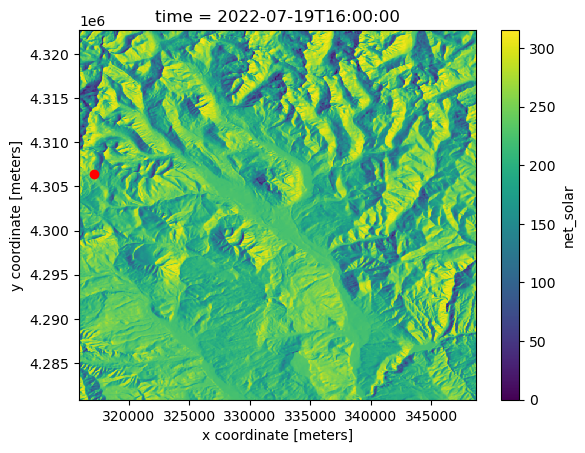

In [77]:
HRRR_solar_0.net_solar.isel(time=7000).plot()
# Add a point at (x, y) coordinates
plt.scatter(snotel_sites.Irwin.lon, snotel_sites.Irwin.lat, color='red')
# 9 AM looks fine

In [33]:
# from osgeo import gdal

# HRRR_solar_0.GetProjection()

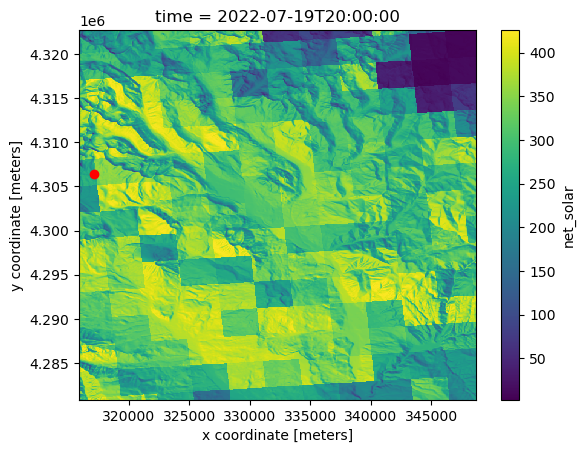

In [78]:
HRRR_solar_0.net_solar.isel(time=7004).plot()
plt.scatter(snotel_sites.Irwin.lon, snotel_sites.Irwin.lat, color='red')
# 1 PM

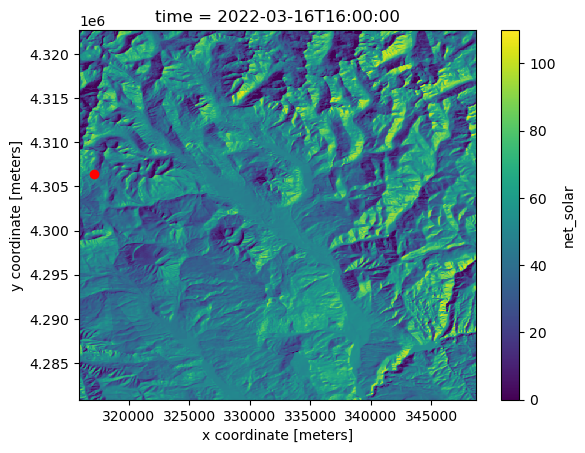

In [82]:
# UTC - 7 (Denver time)
# March 16 9 AM 
HRRR_solar_0.net_solar.isel(time=4000).plot()
plt.scatter(snotel_sites.Irwin.lon, snotel_sites.Irwin.lat, color='red')

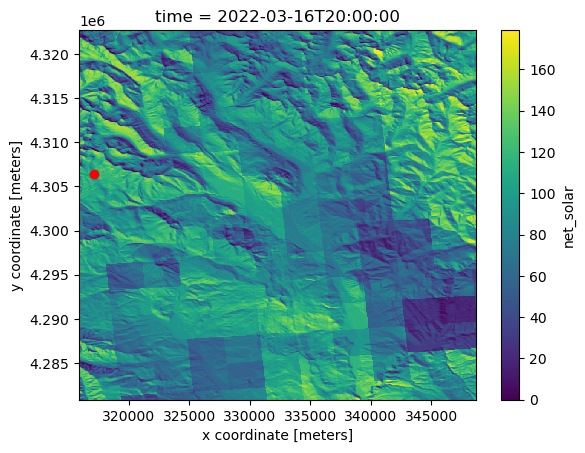

In [83]:
# March 16 1 PM 
HRRR_solar_0.net_solar.isel(time=4004).plot()
plt.scatter(snotel_sites.Irwin.lon, snotel_sites.Irwin.lat, color='red')

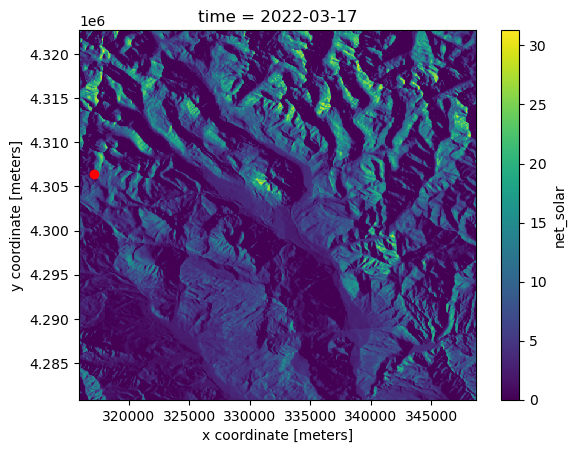

In [85]:
# March 16 9 AM 
HRRR_solar_0.net_solar.isel(time=4008).plot()
plt.scatter(snotel_sites.Irwin.lon, snotel_sites.Irwin.lat, color='red')

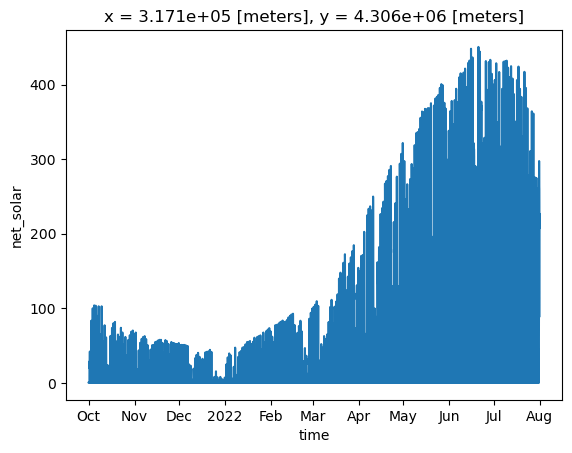

In [35]:
# select temporal values for irwain plot
irwin_snobal_hrrr = HRRR_solar_0.net_solar.sel(x=snotel_sites.Irwin.lon, y=snotel_sites.Irwin.lat, method='nearest').squeeze(['x', 'y']).compute()
irwin_snobal_hrrr.plot.line()

In [36]:
projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,
                                                     semiminor_axis=6371229))

HRRR_solar_proj = HRRR_solar_0.metpy.assign_crs(
    grid_mapping_name = "lambert_conformal_conic",
    latitude_of_projection_origin=xx.dswrf.GRIB_LaDInDegrees,
    longitude_of_central_meridian=xx.dswrf.GRIB_LoVInDegrees,
    standard_parallel=(xx.dswrf.GRIB_Latin1InDegrees, xx.dswrf.GRIB_Latin2InDegrees),
    earth_radius=6371229.)

HRRR_solar_proj = HRRR_solar_proj.metpy.assign_y_x()

/scratch/local/u1037042/2143910/ipykernel_2668810/1811208594.py:14: UserWarning: No y and x coordinates assigned since horizontal coordinates were not found
  HRRR_solar_proj = HRRR_solar_proj.metpy.assign_y_x()


In [70]:
# HRRR_solar_proj

In [37]:
import rioxarray

ModuleNotFoundError: No module named 'rioxarray'

In [38]:
irwin_snobal_hrrr_proj = HRRR_solar_proj.net_solar.sel(x=snotel_sites.Irwin.lon, y=snotel_sites.Irwin.lat, method='nearest').squeeze(['x', 'y']).compute()
irwin_snobal_hrrr_proj

<xarray.DataArray 'net_solar' (time: 7296)> Size: 29kB
array([  0.42664516,   0.        ,   0.        , ..., 207.04594   ,
       226.89696   ,  89.48064   ], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 58kB 2021-10-01 ... 2022-07-31T23:00:00
    x          float32 4B 3.171e+05
    y          float32 4B 4.306e+06
    metpy_crs  object 8B Projection: lambert_conformal_conic
Attributes:
    grid_mapping:  projection

In [50]:
irw_hrrr_df = irwin_snobal_hrrr_proj.to_dataframe()["net_solar"]
irw_hrrr_df

time
2021-10-01 00:00:00      0.426645
2021-10-01 01:00:00      0.000000
2021-10-01 02:00:00      0.000000
2021-10-01 03:00:00      0.000000
2021-10-01 04:00:00      0.000000
                          ...    
2022-07-31 19:00:00    260.118469
2022-07-31 20:00:00    237.176163
2022-07-31 21:00:00    207.045944
2022-07-31 22:00:00    226.896957
2022-07-31 23:00:00     89.480637
Name: net_solar, Length: 7296, dtype: float32

In [59]:
import hvplot.xarray
irwin_snobal_hrrr_proj.rolling(time=24, center=True).mean().hvplot(label='HRRR solar')

:Curve   [time]   (net_solar)

<Axes: xlabel='time'>

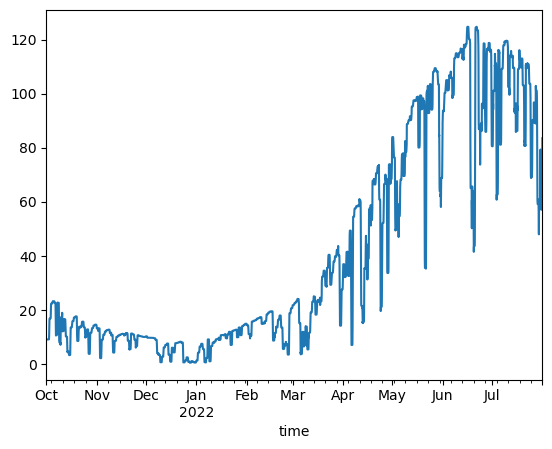

In [66]:
# irwin_snobal_hrrr_proj.fillna({'VIS_IN': 0}).astype(np.float64)
# np.any(np.isnan(irwin_snobal_hrrr_proj))
ROLL_WINDOW = 24
interp_mean = irw_hrrr_df.rolling(ROLL_WINDOW).mean().interpolate("time")
interp_mean.plot.line()

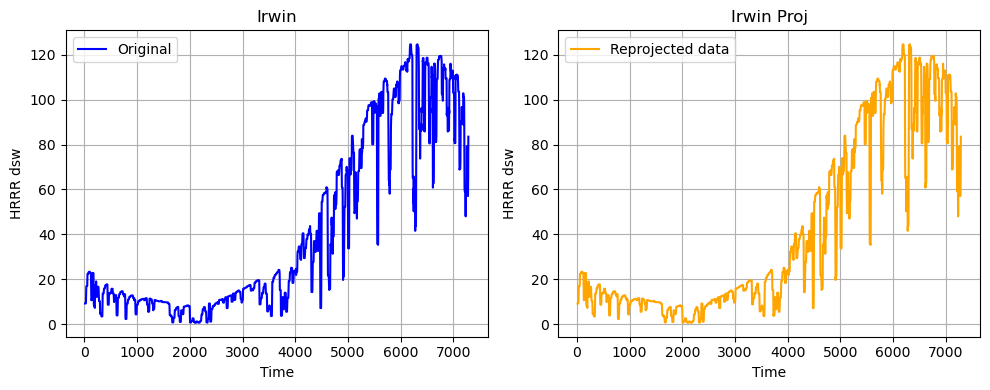

In [71]:
# plot both side-by-side

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first dataset
axs[0].plot(irwin_snobal_hrrr.rolling(time=24, center=True).mean(), color='blue', label='Original')
axs[0].set_title('Irwin')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('HRRR dsw')
axs[0].grid()
axs[0].legend()

# Plot the second dataset
axs[1].plot(irwin_snobal_hrrr_proj.rolling(time=24, center=True).mean(), color='orange', label='Reprojected data')
axs[1].set_title('Irwin Proj')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('HRRR dsw')
axs[1].grid()
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
irwin_snobal_hrrr

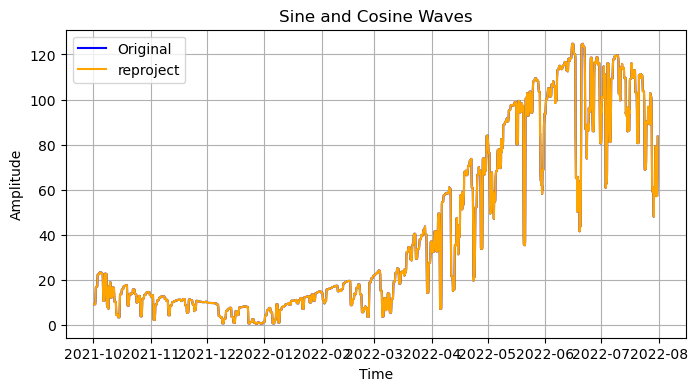

In [72]:
# Time array
time = HRRR_solar_0.net_solar.time

# Two different datasets
data1 = irwin_snobal_hrrr.rolling(time=24, center=True).mean()
data2 = irwin_snobal_hrrr_proj.rolling(time=24, center=True).mean()

# Replace zero values with NaN
data1[data1 == 0] = np.nan
data2[data2 == 0] = np.nan

# Create a single plot
plt.figure(figsize=(8, 4))

# Plot the first dataset
plt.plot(time, data1, color='blue', label='Original')

# Plot the second dataset
plt.plot(time, data2, color='orange', label='reproject')

# Add titles and labels
plt.title('Sine and Cosine Waves')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

# Show the plot
plt.show()



In [73]:
# test if all stations align well with original HRRR data
HRRR_solar_0.net_solar.time

<xarray.DataArray 'time' (time: 7296)> Size: 58kB
array(['2021-10-01T00:00:00.000000000', '2021-10-01T01:00:00.000000000',
       '2021-10-01T02:00:00.000000000', ..., '2022-07-31T21:00:00.000000000',
       '2022-07-31T22:00:00.000000000', '2022-07-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 58kB 2021-10-01 ... 2022-07-31T23:00:00
Attributes:
    standard_name:  time
    long_name:      time
    axis:           T

In [ ]:
# would really like to get DEM and original HRR data around study plot


## TOPO files

In [2]:
import matplotlib.pyplot as plt

from osgeo import gdal, osr

In [3]:

d = "/uufs/chpc.utah.edu/common/home/skiles-group1/jmeyer/project-data/iSnobal/ERW/topo/basin_setup/topo.nc"
topo = gdal.Open(d, gdal.GA_ReadOnly)
topo
topo1 = gdal.Open(topo.GetSubDatasets()[0][0])
spatial_info = osr.SpatialReference()
spatial_info.SetFromUserInput(topo1.GetProjection())
print(spatial_info)

/uufs/chpc.utah.edu/common/home/u1037042/software/pkg/miniconda3/envs/snow_viz/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


PROJCS["WGS84/UTMzone13N",
    GEOGCS["WGS84",
        DATUM["WGS_1984",
            SPHEROID["WGS84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-105],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32613"]]


In [4]:
topo1.GetRasterBand(1).ReadAsArray()

array([[3576.6982, 3589.3613, 3599.5254, ..., 3706.1777, 3714.5654,
        3718.1611],
       [3606.2314, 3619.9102, 3635.7139, ..., 3697.919 , 3706.2686,
        3710.4648],
       [3642.2637, 3665.5771, 3695.791 , ..., 3686.6514, 3695.5586,
        3700.6475],
       ...,
       [3075.3398, 3055.165 , 3040.0723, ..., 2723.9023, 2744.7295,
        2759.0889],
       [3071.4863, 3058.8115, 3056.8164, ..., 2713.3555, 2733.0537,
        2745.6309],
       [3092.045 , 3089.3418, 3094.331 , ..., 2700.457 , 2712.831 ,
        2728.8184]], dtype=float32)

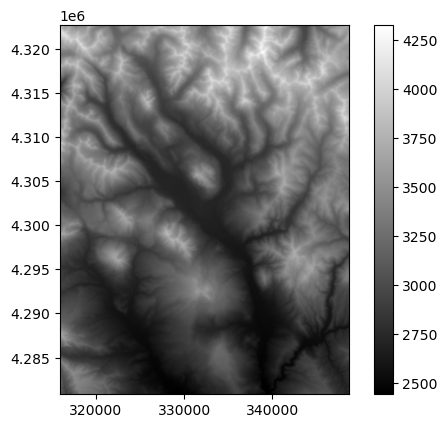

In [5]:
# Read the data from the first band
band = topo1.GetRasterBand(1)
data = band.ReadAsArray()

# Get the geotransform information
geotransform = topo1.GetGeoTransform()

# Plot the data
plt.imshow(data, cmap='gray', extent=[geotransform[0], geotransform[0] + geotransform[1] * topo1.RasterXSize,
                                      geotransform[3] + geotransform[5] * topo1.RasterYSize, geotransform[3]])
plt.colorbar()
plt.show()

### warp original

In [6]:
xx = xr.open_dataset('/uufs/chpc.utah.edu/common/home/skiles-group1/HRRR_water_years/2022/hrrr.20220401/hrrr.t14z.wrfsfcf06.grib2', 
    filter_by_keys={ 'level': 0, 'stepType': 'instant', 'cfVarName': 'dswrf', 'typeOfLevel': 'surface'}, 
    engine="cfgrib")

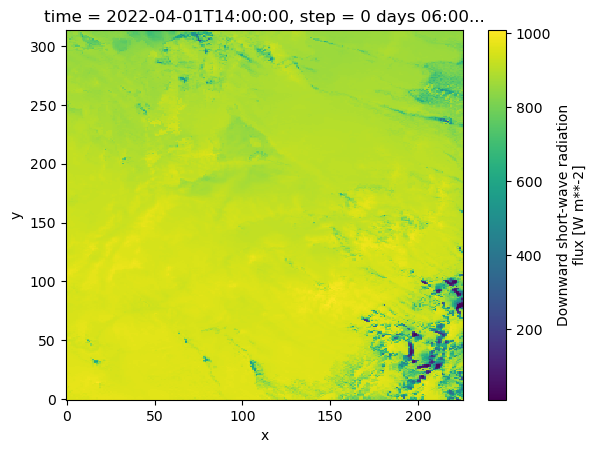

In [7]:
xx.dswrf.plot()

In [90]:
snotel_sites.Irwin

SnotelSite(name='Irwin', lon=[317131], lat=[4306375])

In [147]:
import holoviews as hv
xx.hvplot().opts(width=800, height=800) * \
hv.Points([[snotel_sites.Irwin.lon, snotel_sites.Irwin.lat]]).opts(color="red")

:Overlay
   .Image.I  :Image   [x,y]   (Downward short-wave radiation flux)
   .Points.I :Points   [x,y]

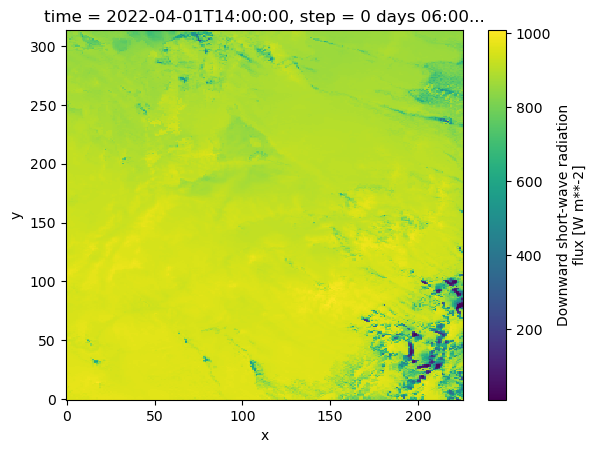

In [79]:
xo = xr.open_dataset('/uufs/chpc.utah.edu/common/home/skiles-group1/HRRR_water_years/2022/hrrr.20220401/hrrr.t14z.wrfsfcf06.grib2', 
    filter_by_keys={ 'level': 0, 'stepType': 'instant', 'cfVarName': 'dswrf', 'typeOfLevel': 'surface'}, 
    engine="cfgrib")
xo.dswrf.plot()

In [48]:
# xp = '/uufs/chpc.utah.edu/common/home/skiles-group1/HRRR_water_years/2022/hrrr.20220401/hrrr.t14z.wrfsfcf06.grib2'
xp = '/uufs/chpc.utah.edu/common/home/skiles-group1/HRRR_water_years/2022/hrrr.20220401/hrrr.t16z.wrfsfcf06.grib2'

xog = gdal.Open(xp)
xog

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fc0646bb480> >

In [49]:
xog.RasterCount

10

In [50]:
xog.GetRasterBand(1).GetMetadata()

{'GRIB_UNIT': '[gpm]',
 'GRIB_COMMENT': 'Geopotential height [gpm]',
 'GRIB_ELEMENT': 'HGT',
 'GRIB_SHORT_NAME': '0-SFC',
 'GRIB_REF_TIME': '1648828800',
 'GRIB_VALID_TIME': '1648850400',
 'GRIB_FORECAST_SECONDS': '21600',
 'GRIB_DISCIPLINE': '0(Meteorological)',
 'GRIB_IDS': 'CENTER=7(US-NCEP) SUBCENTER=0 MASTER_TABLE=2 LOCAL_TABLE=1 SIGNF_REF_TIME=1(Start_of_Forecast) REF_TIME=2022-04-01T16:00:00Z PROD_STATUS=0(Operational) TYPE=1(Forecast)',
 'GRIB_PDS_PDTN': '0',
 'GRIB_PDS_TEMPLATE_NUMBERS': '3 5 2 0 83 0 0 0 1 0 0 0 6 1 0 0 0 0 0 255 0 0 0 0 0',
 'GRIB_PDS_TEMPLATE_ASSEMBLED_VALUES': '3 5 2 0 83 0 0 1 6 1 0 0 255 0 0'}

In [51]:
xog.GetRasterBand(8).GetDescription()

'0[-] BCY="Boundary layer cloud level"'

In [52]:
for i in range(1, xog.RasterCount+1):
    print(i)
    print(xog.GetRasterBand(i).GetDescription())
    


1
0[-] SFC="Ground or water surface"
2
2[m] HTGL="Specified height level above ground"
3
2[m] HTGL="Specified height level above ground"
4
10[m] HTGL="Specified height level above ground"
5
10[m] HTGL="Specified height level above ground"
6
0[-] SFC="Ground or water surface"
7
0[-] SFC="Ground or water surface"
8
0[-] BCY="Boundary layer cloud level"
9
0[-] EATM="Entire Atmosphere"
10
0[-] SFC="Ground or water surface"


In [53]:
for i in range(1, xog.RasterCount+1):
    print(xog.GetRasterBand(i).GetMetadata()['GRIB_COMMENT'])

Geopotential height [gpm]
Temperature [C]
Relative humidity [%]
u-component of wind [m/s]
v-component of wind [m/s]
06 hr Total precipitation [kg/(m^2)]
01 hr Total precipitation [kg/(m^2)]
Total cloud cover [%]
Total cloud cover [%]
Downward short-wave radiation flux [W/(m^2)]


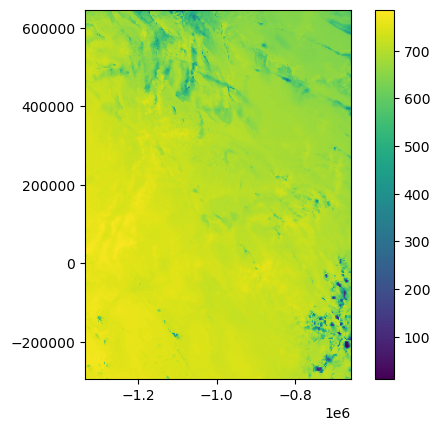

In [56]:
# Read the data from the first band
band_xog_hrrr = xog.GetRasterBand(10)
data_xog_hrrr = band_xog_hrrr.ReadAsArray()

# Get the geotransform information
geotransform = xog.GetGeoTransform()

# Plot the data
plt.figure()
plt.imshow(data_xog_hrrr, cmap='viridis', extent=[geotransform[0], geotransform[0] + geotransform[1] * xog.RasterXSize,
                                      geotransform[3] + geotransform[5] * xog.RasterYSize, geotransform[3]])
plt.colorbar()
plt.show()

In [57]:
# xog.gdal_osr_authority(spatial_info)
spatial_info2 = osr.SpatialReference()
spatial_info2.SetFromUserInput(xog.GetProjection())
print(spatial_info2)

PROJCS["unnamed",
    GEOGCS["Coordinate System imported from GRIB file",
        DATUM["unnamed",
            SPHEROID["Sphere",6371229,0]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]]],
    PROJECTION["Lambert_Conformal_Conic_2SP"],
    PARAMETER["latitude_of_origin",38.5],
    PARAMETER["central_meridian",-97.5],
    PARAMETER["standard_parallel_1",38.5],
    PARAMETER["standard_parallel_2",38.5],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["Metre",1],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH]]


In [18]:
# EXTRACT EPSG CODE FOR DATASET
epsg_code = spatial_info.GetAuthorityName(None) + ":" + spatial_info.GetAuthorityCode(None)
epsg_code

'EPSG:32613'

In [19]:
# extract extent of data
def gdal_output_bounds(topo):
        geo_transform = topo.GetGeoTransform()
        return [
            geo_transform[0],
            geo_transform[3] + geo_transform[5] * topo.RasterYSize,
            geo_transform[0] + geo_transform[1] * topo.RasterXSize,
            geo_transform[3]
        ]

In [58]:
topo1.GetGeoTransform()

(315900.0, 50.0, 0.0, 4322700.0, 0.0, -50.0)

In [59]:
import random
mem_hrrr_file = '/vsimem/grib_%i.tif' % random.getrandbits(32)

In [60]:
# warp options for topo files
options = gdal.WarpOptions(
            dstSRS=epsg_code,
            outputBoundsSRS=epsg_code,
            outputBounds= gdal_output_bounds(topo1),
            xRes=topo1.GetGeoTransform()[1],
            yRes=topo1.GetGeoTransform()[1],
            multithread=True,
        )

# warp file, original, options=topo1
gdal.Warp(mem_hrrr_file, xog, options=options)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fc064454990> >

In [61]:
topo1

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fc07b654c60> >

In [62]:
mem_hrrr_file

'/vsimem/grib_586225630.tif'

In [63]:
hrrr_warp = gdal.Open(mem_hrrr_file, gdal.GA_ReadOnly)
hrrr_warp

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fc062c0bc60> >

In [64]:
xog.GetMetadata()

{}

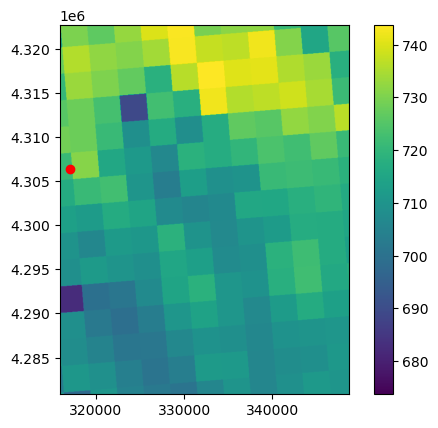

In [70]:
# Read the data from the first band
band_hrrr = hrrr_warp.GetRasterBand(10)
data_hrrr = band_hrrr.ReadAsArray()

# Get the geotransform information
geotransform = hrrr_warp.GetGeoTransform()

# Plot the data
plt.figure()
plt.imshow(data_hrrr, cmap='viridis', extent=[geotransform[0], geotransform[0] + geotransform[1] * hrrr_warp.RasterXSize,
                                      geotransform[3] + geotransform[5] * hrrr_warp.RasterYSize, geotransform[3]])
plt.colorbar()
plt.scatter(snotel_sites.Irwin.lon, snotel_sites.Irwin.lat, color='red')
plt.show()

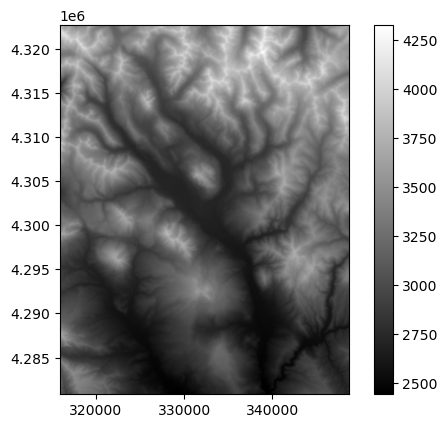

In [132]:
# Read the data from the first band
band = topo1.GetRasterBand(1)
data = band.ReadAsArray()

# Get the geotransform information
geotransform = topo1.GetGeoTransform()

# Plot the data
plt.figure()
plt.imshow(data, cmap='gray', extent=[geotransform[0], geotransform[0] + geotransform[1] * topo1.RasterXSize,
                                      geotransform[3] + geotransform[5] * topo1.RasterYSize, geotransform[3]])
plt.colorbar()
plt.show()

In [71]:
HRRR_solar_0 = xr.open_mfdataset(
    f'{SHARED_STORE}/erw_isnobal/{water_year}/erw_hrrr_solar/run*/net_solar.nc',
    parallel=True, chunks={'time': 24}, # 'y' :10, 'x': 10},
    drop_variables=['DSWRF', 'illumination_angle', 'zenith', 'azimuth', 'albedo_vis', 'albedo_ir'],
)

KeyboardInterrupt: 

In [87]:
HRRR_output_all = xr.open_mfdataset(
    f'{SHARED_STORE}/erw_isnobal/{water_year}/erw_hrrr_solar/run*/net_solar.nc',
    parallel=True, chunks={'time': 24}, # 'y' :10, 'x': 10},
    # drop_variables=['DSWRF', 'illumination_angle', 'zenith', 'azimuth', 'albedo_vis', 'albedo_ir'],
)

In [88]:
HRRR_ouput_all

NameError: name 'HRRR_ouput_all' is not defined

In [ ]:
HRRR_solar_0